In [100]:
import pandas as pd
import re
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle as pkl
import random

In [32]:
df = pd.read_csv('twcs.csv')
df['created_at'] = df['created_at'].apply(lambda x:dt.datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y'))

In [3]:
df.shape

(2811774, 7)

In [4]:
df.head(10)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,2017-10-31 22:10:47,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,2017-10-31 21:54:49,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,2017-10-31 21:49:35,@sprintcare I did.,4,6.0
5,6,sprintcare,False,2017-10-31 21:46:24,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,2017-10-31 22:10:35,@115713 This is saddening to hear. Please shoo...,NaN,12.0
8,12,115713,True,2017-10-31 22:04:47,@sprintcare You gonna magically change your co...,"11,13,14",15.0
9,15,sprintcare,False,2017-10-31 20:03:31,@115713 We understand your concerns and we'd l...,12,16.0


In [5]:
df[df['tweet_id'].isin(list(range(11)))].sort_values(by='created_at')

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
6,8,115712,True,2017-10-31 21:45:10,@sprintcare is the worst customer service,"9,6,10",NaN
2314174,10,sprintcare,False,2017-10-31 21:45:59,@115712 Hello! We never like our customers to ...,NaN,8.0
2314166,9,sprintcare,False,2017-10-31 21:46:14,@115712 I would love the chance to review the ...,NaN,8.0
5,6,sprintcare,False,2017-10-31 21:46:24,@115712 Can you please send us a private messa...,"5,7",8.0
2314173,7,115712,True,2017-10-31 21:47:48,@sprintcare the only way I can get a response ...,NaN,6.0
4,5,115712,True,2017-10-31 21:49:35,@sprintcare I did.,4,6.0
3,4,sprintcare,False,2017-10-31 21:54:49,@115712 Please send us a Private Message so th...,3,5.0
2,3,115712,True,2017-10-31 22:08:27,@sprintcare I have sent several private messag...,1,4.0
0,1,sprintcare,False,2017-10-31 22:10:47,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,2017-10-31 22:11:45,@sprintcare and how do you propose we do that,NaN,1.0


In [6]:
names = [t for t in set(df['author_id'].tolist()) if re.search('[a-zA-Z]', t)]

In [7]:
len(names)

108

In [8]:
print(df[(df['author_id'].isin(names)) & (df['inbound'] == True)].shape[0] == 0)
print(df[~(df['author_id'].isin(names)) & (df['inbound'] == False)].shape[0] == 0)

True
True


In [9]:
print(df[(df['author_id'].isin(names))].shape[0])
print(df[~(df['author_id'].isin(names))].shape[0])

1273931
1537843


In [10]:
# Ratio of tweets posted by customer
1273931/2811774

0.4530701969646209

In [12]:
df_comp = df[df['author_id'].isin(names)]
agg_comp = df_comp[['tweet_id','author_id']].groupby(by=['author_id'], as_index=False).agg(['count'])
agg_comp.columns = agg_comp.columns.droplevel(0)
agg_comp = agg_comp.reset_index()
sort_df = agg_comp.sort_values(by='count',ascending=False)

In [13]:
# Top 10 most active companies
sort_df.head(10)

,author_id,count
8,AmazonHelp,169840
10,AppleSupport,106860
85,Uber_Support,56270
77,SpotifyCares,43265
40,Delta,42253
80,Tesco,38573
9,AmericanAir,36764
78,TMobileHelp,34317
99,comcastcares,33031
33,British_Airways,29361


In [14]:
# Top 10 least active companies
sort_df.tail(10)

,author_id,count
59,MOO,630
95,ask_progressive,612
56,KeyBank_Help,555
21,AskRobinhood,432
103,mediatemplehelp,305
53,JackBox,266
69,OfficeSupport,218
15,AskDSC,210
34,CarlsJr,196
51,HotelTonightCX,152


In [15]:
# Check every in_response_to_tweet_id only contains one float value 
[t for t in df.in_response_to_tweet_id.tolist() if not isinstance(t, float)]

[]

In [16]:
# Number of dialogue
df.in_response_to_tweet_id.isnull().sum()

794335

In [205]:
amaz_df = df[df['author_id'] == 'AmazonHelp']

In [208]:
amaz_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
181,269,AmazonHelp,False,2017-11-22 09:23:01,@115770 こんにちは、アマゾン公式です。Fire TV Stickが見れないというのは...,"270,271",272.0
184,273,AmazonHelp,False,2017-11-22 09:40:27,@115770 カスタマーサービスにてお問い合わせ済みとのことで、お手数をおかけいたしました...,274,271.0
186,275,AmazonHelp,False,2017-11-22 10:06:26,@115770 恐れ入ります。至らない点も多々あるかとは存じますが、今後ともどうぞよろしくお...,NaN,274.0
234,324,AmazonHelp,False,2017-11-22 09:06:00,@115792 ご不便をおかけしております。アプリをご利用でしょうか。強制停止&gt;端末の...,NaN,325.0
321,615,AmazonHelp,False,2017-10-31 22:29:00,@115820 I'm sorry we've let you down! Without ...,616,617.0


## Structure Data

In [328]:
df[df.tweet_id.isin([1299, 1298, 1300, 1301])].sort_values(by='created_at')[['author_id','created_at','text']]

,author_id,created_at,text
756,115951,2017-10-31 22:22:31,@115913 I'm a #TMobile customer getting the ru...
1824751,TMobileHelp,2017-10-31 22:23:27,@115951 @115913 We always want to keep you con...
757,sprintcare,2017-10-31 22:24:30,@115951 Hello please go to the link I will nee...
755,sprintcare,2017-10-31 22:25:24,@115951 Get started here: https://t.co/dYSbRQ3...


In [17]:
class tweet(object):
    """
    An object that holds a single tweet
    """
    def __init__(self, df_row):
        self.tweet_id = df_row.tweet_id
        self.author_id = df_row.author_id
        self.created_at = df_row.created_at
        self.text = df_row.text
        self.response_tweet_id = df_row.response_tweet_id
        self.in_response_to_tweet_id = df_row.in_response_to_tweet_id

In [18]:
class dialogue(object):
    """
    A structured object that organizes dialogue between customer and company agent
    """
    def __init__(self, init_tweet):
        self.tweets = [init_tweet]
        self.ids = {init_tweet.tweet_id}
        self.company = None

In [34]:
candidate = {}
heap = []

for i in df.index.values:
    if i % 100000 == 0:
        print('finished %d rows' % i)
    t = tweet(df.loc[i])
    key = t.in_response_to_tweet_id
    if np.isnan(key):
        heap.append(dialogue(t))
    else:
        if key in candidate:
            candidate[key].append(t)
        else:
            candidate[key] = [t]

# These two numbers should equal
print(len(heap) + sum([len(candidate[k]) for k in candidate]))
print(df.shape[0])

finished 0 rows
finished 100000 rows
finished 200000 rows
finished 300000 rows
finished 400000 rows
finished 500000 rows
finished 600000 rows
finished 700000 rows
finished 800000 rows
finished 900000 rows
finished 1000000 rows
finished 1100000 rows
finished 1200000 rows
finished 1300000 rows
finished 1400000 rows
finished 1500000 rows
finished 1600000 rows
finished 1700000 rows
finished 1800000 rows
finished 1900000 rows
finished 2000000 rows
finished 2100000 rows
finished 2200000 rows
finished 2300000 rows
finished 2400000 rows
finished 2500000 rows
finished 2600000 rows
finished 2700000 rows
finished 2800000 rows
2811774
2811774


In [35]:
# Assign candidate tweets to dialogues
for i in range(len(heap)):
    h = heap[i]
    waiting = {h.tweets[0].tweet_id}
    while len(waiting) > 0:
        tmp_waiting = []
        for idx in waiting:
            try:
                tmp_list = candidate[float(idx)]
                h.tweets += tmp_list
                h.ids.update([t.tweet_id for t in tmp_list])
                tmp_waiting += [t.tweet_id for t in tmp_list]
                del candidate[float(idx)]
            except:
                pass
        waiting = set(tmp_waiting)

In [36]:
len(heap)

794335

In [37]:
length = [len(h.tweets) for h in heap]

(array([  7.94233000e+05,   7.20000000e+01,   1.60000000e+01,
          7.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    2. ,   140.8,   279.6,   418.4,   557.2,   696. ,   834.8,
          973.6,  1112.4,  1251.2,  1390. ]),
 <a list of 10 Patch objects>)

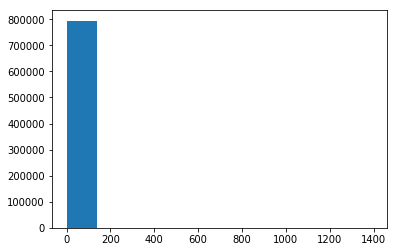

In [38]:
plt.hist(length)

In [42]:
# Number of tweets in a conversation on average
np.mean([len(h.tweets) for h in heap])

3.5197555187672709

In [43]:
min([len(h.tweets) for h in heap])

2

In [44]:
len([1 for h in heap if len(h.tweets) == 2])/len(heap)

0.5466031334386625

In [45]:
max([len(h.tweets) for h in heap])

1390

In [46]:
np.median([len(h.tweets) for h in heap])

2.0

In [29]:
def print_tweets(dialogue, show_id = True):
    """
    Helper function to print tweets in a dialogue
    """
    tweets = sorted(dialogue.tweets, key=lambda k: k.created_at) 
    for t in tweets:
        if show_id:
            print('tweet_id: %s, date: %s, author: %s, text: %s, response_tweet_id: %s, in_response_to_tweet_id: %s' % (t.tweet_id, str(t.created_at), t.author_id, t.text, str(t.response_tweet_id), str(t.in_response_to_tweet_id)))
        else:
            print('date: %s, author: %s, text: %s' % (str(t.created_at), t.author_id, t.text))


In [351]:
# Some of the dialogues suffer from loss of data
count = 0
for h in [_h for _h in heap if len(_h.tweets) == 2]:
    t1, t2 = h.tweets
    if t1.author_id in names or t2.author_id not in names:
        count += 1
        #print_tweets(h)
count / len([_h for _h in heap if len(_h.tweets) == 2])

0.00012206750102490637

In [47]:
# How many dialogues have more than one companies participating
count = 0
s = set()
for h in heap:
    if len(set([t.author_id for t in h.tweets if t.author_id in names])) > 1:
        count += 1
        s.add(h)
        #print_tweets(h)
count / len(heap)

0.0038510200356272855

In [50]:
# Drop these cases
heap = [h for h in heap if len(set([t.author_id for t in h.tweets if t.author_id in names])) == 1]

In [52]:
# Assign company label to each dialogue
for h in heap:
    h.company = [t.author_id for t in h.tweets if t.author_id in names][0]

In [55]:
airlines = [h for h in heap if h.company in ['Delta', 'AmericanAir', 'British_Airways']]

(array([ 25804.,      0.,      0.,      0.,      0.,  16303.,      0.,
             0.,      0.,  25813.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

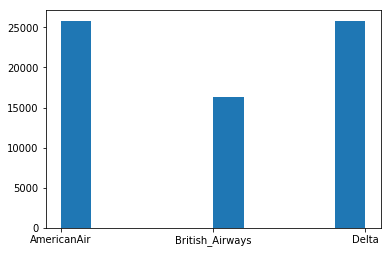

In [56]:
plt.hist([h.company for h in airlines])

In [57]:
# Number of dialogues in airline companies
len(airlines)

67920

In [58]:
length = [len(h.tweets) for h in airlines]

(array([  6.77920000e+04,   9.40000000e+01,   1.70000000e+01,
          5.00000000e+00,   5.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   2. ,   22.2,   42.4,   62.6,   82.8,  103. ,  123.2,  143.4,
         163.6,  183.8,  204. ]),
 <a list of 10 Patch objects>)

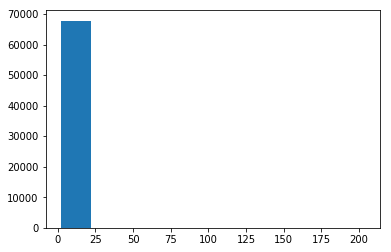

In [60]:
plt.hist(length)

In [81]:
# Simplify the dataset into question answering pairs
# TODO: Filter out some long conversations that appear to be open discussions instead question answering.
airlines_sim = [d for d in airlines if len(d.tweets) == 2]
len(airlines_sim)

37383

In [ ]:
# For eye-ball checking
'''
for h in airlines:
    if len(h.tweets) == 3 and h.tweets[-1].author_id in names:
        print_tweets(h)
        print('*'*10)
'''

In [96]:
# Further filter out non question answering conversation
data = []
for d in airlines_sim:
    if any(s in d.tweets[0].text.lower() for s in ['how', 'when', 'what', 'where', 'who', 'which', '?']):
        data.append(d)
           
len(data)

13681

In [99]:
class vector_model(object):
    """
    Object holding item to index map and item vectors
    """
    def __init__(self, item_map, vectors):
        self.item_map = item_map
        self.vectors = vectors
        self.num_items = vectors.shape[0]
        self.dim = vectors.shape[1]
    def get_nearest(self, candidate_vector, topk = 1, ex_self = True):
        if candidate_vector.shape != (1, self.dim):
            candidate_vector = candidate_vector.reshape(1, self.dim)
        score = self.vectors.dot(candidate.T)
        if score.shape != (self.num_items):
            score = score.reshape(self.num_items)
        top_index = score.argsort()[::-1][:topk].tolist()
        return top_index

In [131]:
train = []
test = []
for d in data:
    if random.random() > 0.9:
        test.append(d.tweets[0].text)
    else:
        train.append(d.tweets[0].text)

In [181]:
item_map = {}
cv = CountVectorizer(ngram_range = (1, 2), stop_words = 'english')
vectors = cv.fit_transform(train).toarray()
#vectors = []
cnt = 0
for t in train:
    item_map[t] = cnt
    cnt += 1
    #vectors.append(cv.transform([t]).toarray()[0].tolist())